
<image src="https://github.com/semilleroCV/Hands-on-Computer-Vision/blob/2024/Sesiones/Sesion5/Parte%201/images/cover-page.png?raw=true" width=100%>



# <center> **04. Estimación pasiva de la profundidad** </center>

La estimación pasiva de la profundidad es el conjunto de técnicas y algoritmos para estimar la distancia observada de objetos para permitir una comprensión tridimensional (3D) del entorno circundante. Durante esta sesión vamos a aplicar los conceptos explicados, **para estimar la disparidad en imágenes estéreo prediseñadas mediante diversas técnicas de programación y así obtener los mapas de disparidad y profundidad.**

<!-- ## **Contenido** -->

<!-- [**0. Introducción a la visión estéreo**](#tema1)

[**1. Caso 1: Imagenes Rectificadas**](#tema2)

&emsp;&emsp;[**1.1. Disparidad**](#tema3)

&emsp;&emsp;[**1.2. Profundidad**](#tema4)

&emsp;&emsp;[**1.3. PointCloud - 3D**](#tema5)

[**2. Caso 2: Imágenes No Rectificadas**](#tema6)

&emsp;&emsp;[**2.1 Calibración de camara**](#tema7)

&emsp;&emsp;[**2.2. Rectificación**](#tema8)

&emsp;&emsp;&emsp;&emsp;&emsp; [**2.2.1 Geometría epipolar**](#tema9)

&emsp;&emsp;&emsp;&emsp;&emsp; [**2.2.2 Conceptos**](#tema10)

&emsp;&emsp;&emsp;&emsp;&emsp; [**2.2.3 KeyPoints**](#tema11)

&emsp;&emsp;&emsp;&emsp;&emsp;[**2.2.4 Matriz Fundamental**](#tema12)

&emsp;&emsp;&emsp;&emsp;&emsp;[**2.2.5 Lineas epipolares**](#tema13)

&emsp;&emsp;&emsp;&emsp;&emsp;[**2.2.6 Homografías**](#tema14)

&emsp;&emsp;[**2.3 Disparidad**](#tema15)

&emsp;&emsp;[**2.4 Profundidad**](#tema16)

&emsp;&emsp;[**2.5 PointCloud -3D**](#tema17) -->

In [1]:
#@title **Instalamos Paquetes necesarios**
!pip install plotly -q
!pip install timm -q

In [61]:
#@title descargamos las imágenes
!wget -O /content/28.png https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/f0142bf70526f90218f13836038e94cca4d94e7d/sesiones/sesion5/28.png
!wget -O /content/color.png https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/f0142bf70526f90218f13836038e94cca4d94e7d/sesiones/sesion5/color.png

--2025-04-07 22:09:21--  https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/f0142bf70526f90218f13836038e94cca4d94e7d/sesiones/sesion5/28.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83645 (82K) [image/png]
Saving to: ‘/content/28.png’

/content/28.png     100%[===================>]  81.68K  --.-KB/s    in 0.02s   

2025-04-07 22:09:21 (3.74 MB/s) - ‘/content/28.png’ saved [83645/83645]

--2025-04-07 22:09:21--  https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/f0142bf70526f90218f13836038e94cca4d94e7d/sesiones/sesion5/color.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.co

In [2]:
#@title **Cargamos las librerias**
import os
import cv2
import torch
import random
import requests
import numpy as np
import ipywidgets as widgets
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec

from io import BytesIO
import torch.nn.functional as F
from torchvision.transforms import Compose
from IPython.display import display
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [55]:
# @title prerequisitos
import torch
from torchvision import transforms

def image2tensor(raw_image, input_size=518):
    h, w = raw_image.shape[:2]
    image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    image_tensor = transform(image).unsqueeze(0)  # Añade batch dimension

    device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
    image_tensor = image_tensor.to(device)

    return image_tensor, (h, w)

def plot_depth(depth):
  fig, ax = plt.subplots(figsize=(8, 6))

  img = ax.imshow(np.array(depth) , cmap='magma')
  ax.axis('off')

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.1)

  cbar = plt.colorbar(img, cax=cax)
  cbar.set_label('Depth')
  plt.tight_layout()
  plt.show()

def get_line(predicted_image, true_depth_image):
  x_axis = predicted_image.flatten()
  y_axis = true_depth_image.flatten()

  mask = np.isfinite(x_axis) & np.isfinite(y_axis)
  x_axis = x_axis[mask]
  y_axis = y_axis[mask]

  if len(x_axis) < 2:
      return None, None, None, None

  a, b = np.polyfit(x_axis, y_axis, 1)
  return a, b, x_axis, y_axis



def compute_scale_and_shift(prediction, target):
    """
    Compute scale and shift to align the 'prediction' to the 'target' using the 'mask'.

    This function solves the system Ax = b to find the scale (x_0) and shift (x_1) that aligns the prediction to the target.
    The system matrix A and the right hand side b are computed from the prediction, target, and mask.

    Args:
        prediction (torch.Tensor): Predicted values.
        target (torch.Tensor): Ground truth values.
        mask (torch.Tensor): Mask that indicates the zones to evaluate.

    Returns:
        tuple: Tuple containing the following:
            x_0 (torch.Tensor): Scale factor to align the prediction to the target.
            x_1 (torch.Tensor): Shift to align the prediction to the target.
    """
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(prediction * prediction, (1, 2))
    a_01 = torch.sum(prediction, (1, 2))
    a_11 = torch.sum(torch.ones_like(prediction), (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(prediction * target, (1, 2))
    b_1 = torch.sum(target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    # A needs to be a positive definite matrix.
    valid = det > 0

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1

## <font color='#4C5FDA'>**1. Estimación monocular de la profundidad**</font> <a name="tema1">




### <font color="EB9A54"> **1.1:** </font> Probemos modelos fundacionales de estimación monocular

##**Inferencia**

In [7]:
# @title **Descargamos DepthAnything v2**

# Depth Anything V2
%cd /content/
!git clone https://github.com/DepthAnything/Depth-Anything-V2
%cd /content/Depth-Anything-V2
!mkdir -p /content/Depth-Anything-V2/checkpoints/
!pip install -r requirements.txt -q

!wget -O /content/Depth-Anything-V2/checkpoints/depth_anything_v2_vits.pth https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth

%cd /content/

/content
fatal: destination path 'Depth-Anything-V2' already exists and is not an empty directory.
/content/Depth-Anything-V2
--2025-04-07 21:07:17--  https://huggingface.co/depth-anything/Depth-Anything-V2-Small/resolve/main/depth_anything_v2_vits.pth
Resolving huggingface.co (huggingface.co)... 3.166.152.65, 3.166.152.44, 3.166.152.105, ...
Connecting to huggingface.co (huggingface.co)|3.166.152.65|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/7d/71/7d7123d318b185378add474d70b5e65a928d3c609aa5ac7a16d498cea6b2bad9/715fade13be8f229f8a70cc02066f656f2423a59effd0579197bbf57860e1378?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27depth_anything_v2_vits.pth%3B+filename%3D%22depth_anything_v2_vits.pth%22%3B&Expires=1744063637&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NDA2MzYzN319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzdkLzcxLzdkNzEyM2QzMThiMTg

/content/Depth-Anything-V2


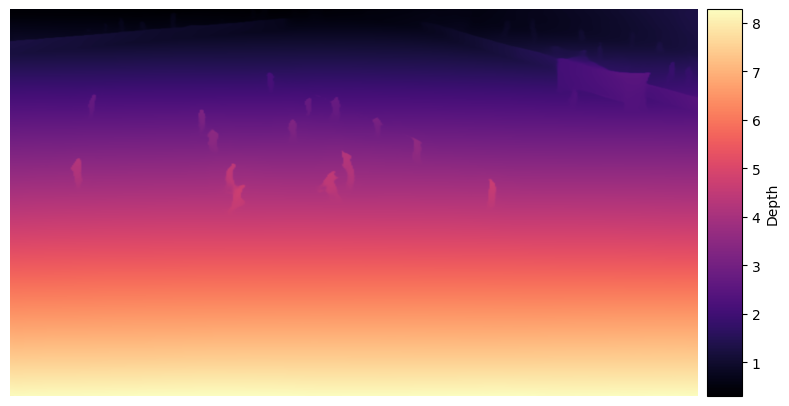

In [23]:
# @title **DepthAnything V2**
%cd /content/Depth-Anything-V2
from depth_anything_v2.dpt import DepthAnythingV2
from PIL import Image

# Ruta de la imagen
rgb = '/content/color.png'

# Carga la imagen y la convierte a tensor
raw_image = cv2.imread(rgb)
image_tensor, (h, w) = image2tensor(raw_image)

# Configuración del modelo
model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}

encoder = 'vits'  # puede ser también 'vitb', 'vitl', 'vitg'

# Carga del modelo
os.makedirs("checkpoints", exist_ok=True)
model = DepthAnythingV2(**model_configs[encoder])
model.load_state_dict(torch.load(f'checkpoints/depth_anything_v2_{encoder}.pth', map_location='cpu'))

device = image_tensor.device
model = model.to(device).eval()

# Inferencia
with torch.no_grad():
    depth_dav2 = model(image_tensor)
    depth_dav2 = F.interpolate(depth_dav2[:, None], (h, w), mode="bilinear", align_corners=True)[0, 0]

depth_dav2 = depth_dav2.cpu().numpy()

# Visualización
plot_depth(depth_dav2)

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


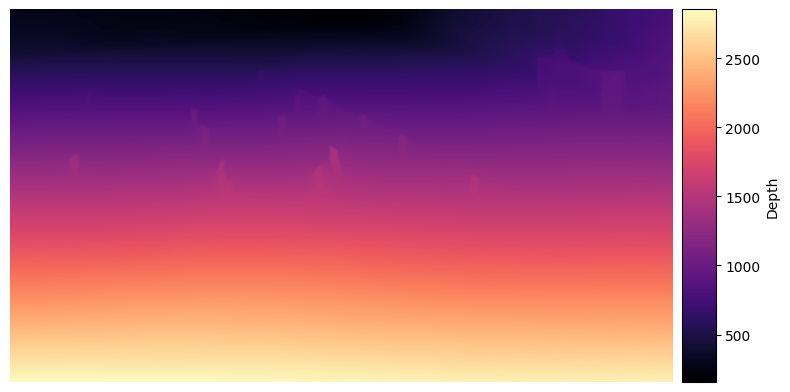

In [33]:
# @title **MiDaS**
model_type = "DPT_Hybrid"

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

img = cv2.imread(rgb)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
    depth_midas = midas(input_batch)

    depth_midas = torch.nn.functional.interpolate(
        depth_midas.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_midas = depth_midas.cpu().numpy()
plot_depth(depth_midas)

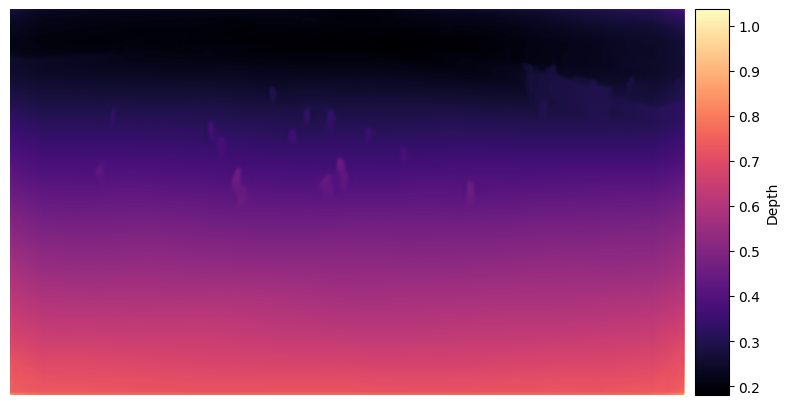

In [29]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
from PIL import Image

# Configura el dispositivo
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

# Carga el modelo y el procesador
processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu-kitti")
model = AutoModelForDepthEstimation.from_pretrained("Intel/zoedepth-nyu-kitti").to(device)

# Carga y convierte la imagen
image = Image.open(rgb).convert("RGB")

# Procesa la imagen y mueve al dispositivo
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predicción
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth.squeeze().cpu().numpy()

# Inversa de profundidad para visualización
predicted_depth_r = 1.0 / (predicted_depth + 1e-6)
plot_depth(predicted_depth_r)


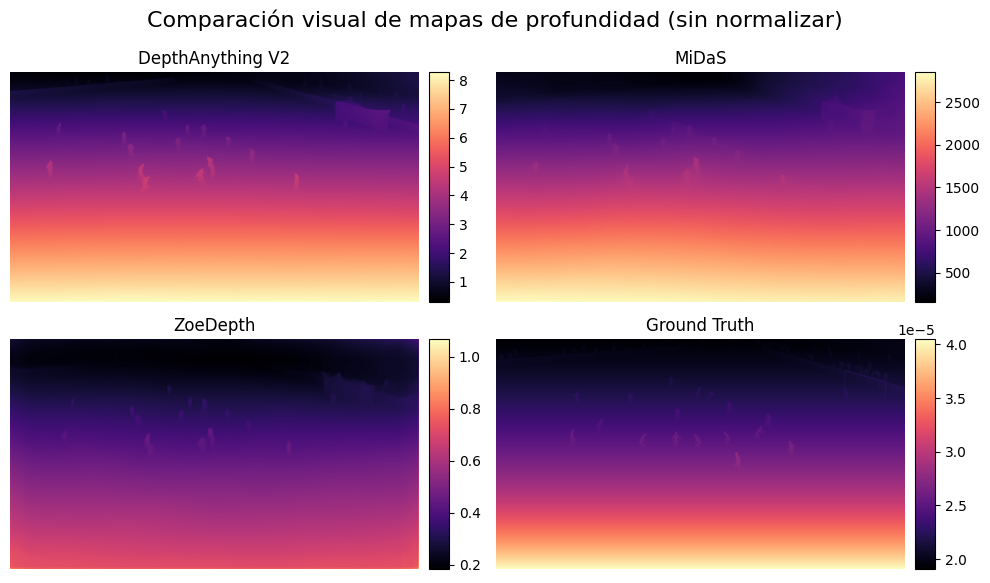

In [47]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Cargar ground truth
true_depth = cv2.imread("/content/28.png", cv2.IMREAD_UNCHANGED).astype(np.float32)
true_depth = 1.0 / (true_depth + 1e-6)

# Redimensionar las predicciones al tamaño del ground truth
depth_dav2_resized = cv2.resize(depth_dav2, (true_depth.shape[1], true_depth.shape[0]), interpolation=cv2.INTER_CUBIC)
depth_midas_resized = cv2.resize(depth_midas, (true_depth.shape[1], true_depth.shape[0]), interpolation=cv2.INTER_CUBIC)
depth_zoe_resized = cv2.resize(predicted_depth_r, (true_depth.shape[1], true_depth.shape[0]), interpolation=cv2.INTER_CUBIC)

# Preparar plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

titles = ["DepthAnything V2", "MiDaS", "ZoeDepth", "Ground Truth"]
depth_maps = [depth_dav2_resized, depth_midas_resized, depth_zoe_resized, true_depth]

for ax, title, depth_map in zip(axes.flat, titles, depth_maps):
    im = ax.imshow(depth_map, cmap='magma')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

plt.suptitle("Comparación visual de mapas de profundidad (sin normalizar)", fontsize=16)
plt.tight_layout()
plt.show()

<ipython-input-38-228bd7d4dfc5>:49: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x_axis, y_axis, 1)
<ipython-input-38-228bd7d4dfc5>:49: RankWarning: Polyfit may be poorly conditioned
  a, b = np.polyfit(x_axis, y_axis, 1)
<ipython-input-48-5353b64a8371>:54: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


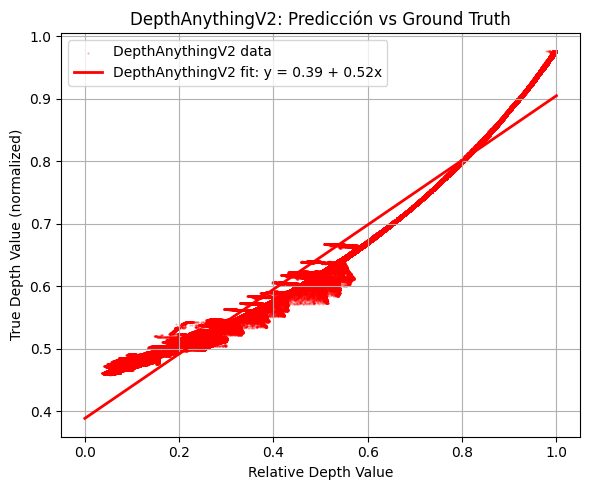

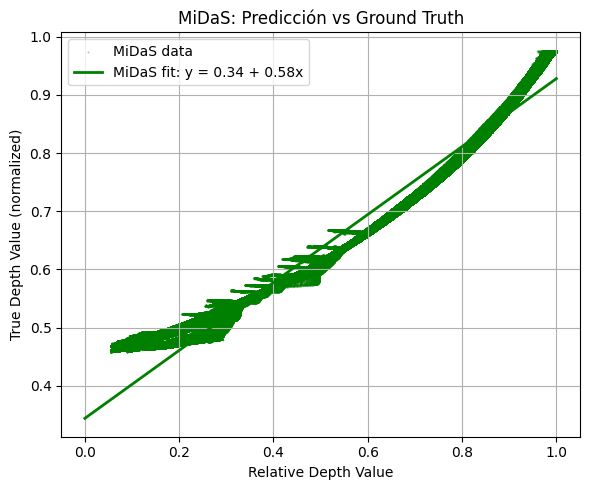

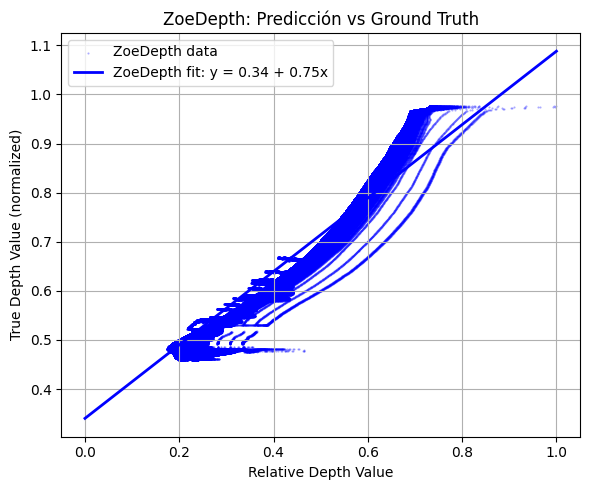

In [48]:
true_depth = cv2.imread("/content/28.png", cv2.IMREAD_UNCHANGED).astype(np.float32)
true_depth = 1.0 / (true_depth + 1e-6)
true_depth /= np.max(true_depth) + 1e-6  # Normalización

resultados = {}
datos_plot = {}

# --- DepthAnything V2 ---
depth_dav2_rescaled = depth_dav2 / (np.max(depth_dav2) + 1e-6)
depth_dav2_rescaled = cv2.resize(depth_dav2_rescaled, (true_depth.shape[1], true_depth.shape[0]))

a_da, b_da, x_da, y_da = get_line(depth_dav2_rescaled, true_depth)
resultados["DepthAnythingV2"] = (a_da, b_da)
datos_plot["DepthAnythingV2"] = (x_da, y_da)

# --- MiDaS ---
depth_midas_rescaled = depth_midas / (np.max(depth_midas) + 1e-6)
depth_midas_rescaled = cv2.resize(depth_midas_rescaled, (true_depth.shape[1], true_depth.shape[0]))

a_midas, b_midas, x_midas, y_midas = get_line(depth_midas_rescaled, true_depth)
resultados["MiDaS"] = (a_midas, b_midas)
datos_plot["MiDaS"] = (x_midas, y_midas)

# --- ZoeDepth ---
depth_zoe_rescaled = predicted_depth_r / (np.max(predicted_depth_r) + 1e-6)
depth_zoe_rescaled = cv2.resize(depth_zoe_rescaled, (true_depth.shape[1], true_depth.shape[0]))

a_zoe, b_zoe, x_zoe, y_zoe = get_line(depth_zoe_rescaled, true_depth)
resultados["ZoeDepth"] = (a_zoe, b_zoe)
datos_plot["ZoeDepth"] = (x_zoe, y_zoe)


colors = {
    "DepthAnythingV2": "red",
    "MiDaS": "green",
    "ZoeDepth": "blue"
}

for name, (a, b) in resultados.items():
    x_vals, y_vals = datos_plot[name]

    plt.figure(figsize=(6, 5))
    plt.scatter(x_vals, y_vals, s=0.3, alpha=0.3, color=colors[name], label=f"{name} data")

    x_line = np.linspace(0, 1, 100)
    y_line = a * x_line + b
    plt.plot(x_line, y_line, color=colors[name], linewidth=2, label=f"{name} fit: y = {b:.2f} + {a:.2f}x")

    plt.title(f"{name}: Predicción vs Ground Truth")
    plt.xlabel("Relative Depth Value")
    plt.ylabel("True Depth Value (normalized)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
